# MODULE 3
---
## Task Summary
- Filter 5+ items basket
- Model that predicts whether the customer will buy the item or not
- TARGET: Increase monthly sales by 2% and boost selected items >25%

### Exploration phase
1. Filter data to orders with 5+ items
2. Just linear models with 3-way split (train/validation/test)
3. Select a final model to move to the next step

### MVP Code
Production-ready code for our pipeline
1. Data loading
2. Preprocessing
3. Model training/selection: train different models and evaluate performance. Train a final model and save. Think what is a good standard to save the trained models to keep track of the history of the models.

In [1]:
import boto3
import os
from dotenv import find_dotenv, load_dotenv
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [ ]:
# Find .env
dotenv_path = find_dotenv()
# Load entries as environment variables
load_dotenv(dotenv_path)

# Get .env variables
ACCESS_KEY_ID = os.getenv('ACCESS_KEY_ID')
SECRET_ACCESS_KEY = os.getenv('SECRET_ACCESS_KEY')

s3_client = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY_ID,
    aws_secret_access_key=SECRET_ACCESS_KEY
)

s3_resource = boto3.resource('s3')

response = s3_client.list_objects_v2(Bucket='zrive-ds-data')
objects = response.get('Contents', [])

In [ ]:
# Search for .csv files
for obj in objects:
    key = obj['Key']
    if key.endswith('.csv'):
        print(key)

In [ ]:
s3_client.download_file(Bucket = 'zrive-ds-data', 
                        Key = 'groceries/box_builder_dataset/feature_frame.csv',
                        Filename = 'feature_frame.csv')

## Filtering data

In [31]:
path = '../Data/'
feature_frame = pd.read_csv(path+'feature_frame.csv')
feature_frame.tail()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.11436,colief,0.0,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.11436,colief,0.0,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.11436,colief,0.0,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,33826439594116,healthcarevitamins,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.11436,colief,0.0,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880548,33826439594116,healthcarevitamins,3643301986436,3914253959300,2021-03-03 14:42:05,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.11436,colief,0.0,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [3]:
feature_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
len(feature_frame['order_id'].drop_duplicates().dropna())

3446

In [5]:
(feature_frame.groupby('order_id')['outcome'].sum()>=5).sum()

np.int64(2603)

We have 3446 different baskets -> 2603 with 5+ items bought

In [6]:
def filter_df_ordersize(df: pd.DataFrame, min_product: int = 5) -> pd.DataFrame:
    mask = feature_frame.groupby('order_id')['outcome'].sum().ge(5)
    order_ids_filtered = mask[mask].index
    return df.loc[lambda x: x.order_id.isin((order_ids_filtered))]

df_feature = filter_df_ordersize(feature_frame).copy()

In [7]:
df_feature.created_at = pd.to_datetime(df_feature.created_at)
df_feature.order_date = pd.to_datetime(df_feature.order_date).dt.date

In [8]:
df_feature.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [9]:
df_feature.isnull().sum()

variant_id                          0
product_type                        0
order_id                            0
user_id                             0
created_at                          0
order_date                          0
user_order_seq                      0
outcome                             0
ordered_before                      0
abandoned_before                    0
active_snoozed                      0
set_as_regular                      0
normalised_price                    0
discount_pct                        0
vendor                              0
global_popularity                   0
count_adults                        0
count_children                      0
count_babies                        0
count_pets                          0
people_ex_baby                      0
days_since_purchase_variant_id      0
avg_days_to_buy_variant_id          0
std_days_to_buy_variant_id          0
days_since_purchase_product_type    0
avg_days_to_buy_product_type        0
std_days_to_

<Axes: xlabel='order_date', ylabel='order_id count'>

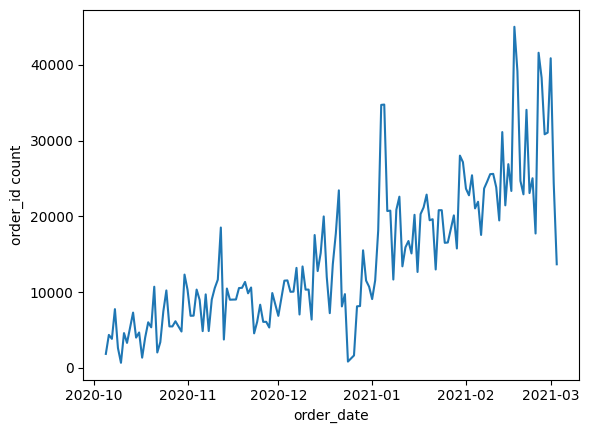

In [10]:
df_feature.groupby('order_date')['order_id'].count().plot(kind = 'line', ylabel='order_id count')

It can be clearly seen how the evolution of sales is increasing with the past of time, so it could be stated that for the split (train-test-validation) we are going to split the data temporarily. In this way we avoid data leakage backwards.

## 🚫 DON´T RUN THIS SUBSECTION — Incorrect first approach

### PreProcessing

In [10]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
TARGET = 'outcome'

GROUP = 'user_id'

info_cols = ['variant_id', 'order_id', 'created_at', 'order_date']

FEATURES = [col for col in df_feature.columns if col not in info_cols + [TARGET] ]

# I should check if global popularity is linked to the time of purchase, or if there are some things that were bought previously that now not, etc.
FEATURES = ['product_type_encoded', 'vendor_encoded',
             'ordered_before', 'abandoned_before', 'set_as_regular', 'active_snoozed',
             'price_with_discount', 'global_popularity', 
             'count_adults', 'count_children', 'count_babies', 'count_pets',
             ]

In [11]:
## Creating a new column for the normalised price with discount applied
df_feature['price_with_discount'] = df_feature['normalised_price'] * (1 - df_feature['discount_pct']/100.)

C:\Users\jontx\AppData\Local\Temp\ipykernel_18264\3750851884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature['price_with_discount'] = df_feature['normalised_price'] * (1 - df_feature['discount_pct']/100.)


In [12]:
print(f'There are {df_feature.vendor.nunique()} vendors and {df_feature.product_type.nunique()} products')
print(f'There are {df_feature.vendor.value_counts().nunique()} unique frequencies for vendors')

There are 264 vendors and 62 products
There are 139 unique frequencies for vendors


In [13]:
le = LabelEncoder()
le.fit(df_feature['vendor'].unique())
df_feature['vendor_encoded'] = le.transform(df_feature['vendor'])

le.fit(df_feature['product_type'].unique())
df_feature['product_type_encoded'] = le.transform(df_feature['product_type'])

df_feature.describe()

C:\Users\jontx\AppData\Local\Temp\ipykernel_18264\484010771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature['vendor_encoded'] = le.transform(df_feature['vendor'])
C:\Users\jontx\AppData\Local\Temp\ipykernel_18264\484010771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature['product_type_encoded'] = le.transform(df_feature['product_type'])


,variant_id,order_id,user_id,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,price_with_discount,vendor_encoded,product_type_encoded
count,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06,2.163953e+06
mean,3.401022e+13,2.970615e+12,3.731338e+12,3.414455e+00,1.447767e-02,2.548530e-02,7.416982e-04,2.844794e-03,4.285213e-03,1.271294e-01,1.864700e-01,1.078504e-02,2.023446e+00,6.875196e-02,4.074488e-03,6.584801e-02,2.092198e+00,3.316272e+01,3.529397e+01,2.650028e+01,3.172204e+01,3.090521e+01,2.596460e+01,1.269080e-01,1.240767e+02,3.088828e+01
std,2.775294e+11,2.377644e+11,1.845180e+11,2.287832e+00,1.194490e-01,1.575938e-01,2.722404e-02,5.326070e-02,6.532115e-02,1.267182e-01,1.936836e-01,1.663036e-02,2.384079e-01,3.656065e-01,6.370156e-02,3.419694e-01,4.419435e-01,4.094441e+00,1.055518e+01,7.137545e+00,1.333857e+01,4.308186e+00,3.256241e+00,1.265253e-01,7.460350e+01,1.733632e+01
min,3.361529e+13,2.807986e+12,3.046041e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.599349e-02,-4.016064e-02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.414214e+00,0.000000e+00,7.000000e+00,2.828427e+00,1.595012e-02,0.000000e+00,0.000000e+00
25%,3.380354e+13,2.872605e+12,3.528874e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.394416e-02,8.633094e-02,1.633987e-03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.000000e+01,2.322056e+01,3.000000e+01,2.800000e+01,2.427618e+01,5.386284e-02,5.700000e+01,1.500000e+01
50%,3.397325e+13,2.900909e+12,3.806872e+12,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.105178e-02,1.169176e-01,6.342495e-03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.400000e+01,2.769305e+01,3.000000e+01,3.100000e+01,2.608188e+01,8.095419e-02,1.200000e+02,3.100000e+01
75%,3.428495e+13,2.920994e+12,3.869945e+12,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.352670e-01,2.234637e-01,1.432881e-02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,4.000000e+01,3.062510e+01,3.000000e+01,3.400000e+01,2.796118e+01,1.351288e-01,1.820000e+02,4.700000e+01
max,3.454300e+13,3.643295e+12,5.023381e+12,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.325301e+00,4.254386e-01,5.000000e+00,3.000000e+00,1.000000e+00,6.000000e+00,5.000000e+00,1.480000e+02,8.400000e+01,5.868986e+01,1.480000e+02,3.950000e+01,3.564191e+01,9.988859e-01,2.630000e+02,6.100000e+01


In [14]:
df_feature.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type', 'price_with_discount', 'vendor_encoded',
       'product_type_encoded'],
      dtype='object')

### Models selection

#### 1st create the splits
- What I want to predict is whether a customer will buy or not an item. I think is a good approach not to use the same user for different sets, so I will try to have different unique users in each of the 3 sets.
- I think that it is also important to have same products along 3 sets, to check whether the trained model for these products work for other users.
- I also want to have users that bought the products in all sets, so I can train, test and validate positive-buyer profiles

*¡¡ Using variables like 'days_since_purchase' would lead to **data leakage** because in production we won´t have this information !!*

In [15]:
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit, cross_val_score
from sklearn.metrics import (average_precision_score, precision_score, precision_recall_curve, recall_score)
from sklearn.preprocessing import StandardScaler

# Candidate models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

In [17]:
X = df_feature[FEATURES]
y = df_feature[TARGET]

In [21]:
print(y.sum()/len(y) * 100)

1.4477671187867758


In [25]:
print(tv[TARGET].sum()/len(tv[TARGET]))

0.014509003994747197


In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_val_idx, test_idx = next(gss.split(df_feature, groups=df_feature[GROUP]))
tv = df_feature.iloc[train_val_idx].reset_index(drop=True)
test = df_feature.iloc[test_idx].reset_index(drop=True)
X_test, y_test = test[FEATURES], test[TARGET]

scaler = StandardScaler()
X_test = scaler.fit(X_test)

sgk = StratifiedGroupKFold(n_splits = 5, shuffle=True, random_state=43)
reg = [1, 10, 50]

for a in reg:
    clf = LogisticRegression(C = a)
    score = cross_val_score(clf, tv[FEATURES], tv[TARGET], groups=tv[GROUP], cv=sgk, scoring = 'precision')
    
    print(f'Score for C = {a} on cross validation is {score}')
    print(f'Mean score for C = {a} on cross validation is {score.mean()}')
# for fold, (tr_idx, val_idx) in enumerate(sgk.split(tv[FEATURES], y = tv[TARGET], groups=tv[GROUP])):
#     train = tv.iloc[tr_idx]
#     val = tv.iloc[val_idx]
#     X_train, y_train = train[FEATURES], train[TARGET]
#     X_val, y_val = val[FEATURES], val[TARGET]

#     clf.fit(X_train, y_train)

#     d_val = clf.decision_function(X_val)

#     prec, rec, thr = precision_recall_curve(y_val, d_val)
    

c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame

Score for C = 1 on cross validation is [0. 0. 0. 0. 0.]
Mean score for C = 1 on cross validation is 0.0


KeyboardInterrupt: 

In [65]:
# 1) test vs train/val pool
users_tv, users_test = set(tv[GROUP].unique()), set(test[GROUP].unique())
assert users_tv.isdisjoint(users_test), "Users leak between tv and test!"
print("OK: test users disjoint from train/val pool.")

# 2) per-fold disjointness + quick diagnostics
for fold, (tr_idx, va_idx) in enumerate(sgk.split(tv[x_var], y=tv[TARGET], groups=tv[GROUP]), 1):
    u_tr  = set(tv.iloc[tr_idx][GROUP].unique())
    u_val = set(tv.iloc[va_idx][GROUP].unique())
    assert u_tr.isdisjoint(u_val), f"Fold {fold}: train/val share users!"
    assert u_tr.isdisjoint(users_test) and u_val.isdisjoint(users_test), f"Fold {fold}: leakage vs test!"
    print(f"fold {fold}: users train={len(u_tr)} val={len(u_val)} "
          f"pos_rate_tr={tv.iloc[tr_idx][TARGET].mean():.4f} "
          f"pos_rate_val={tv.iloc[va_idx][TARGET].mean():.4f}")
print("All folds OK.")

OK: test users disjoint from train/val pool.
fold 1: users train=1032 val=257 pos_rate_tr=0.0144 pos_rate_val=0.0148
fold 2: users train=1032 val=257 pos_rate_tr=0.0146 pos_rate_val=0.0140
fold 3: users train=1031 val=258 pos_rate_tr=0.0146 pos_rate_val=0.0141
fold 4: users train=1030 val=259 pos_rate_tr=0.0145 pos_rate_val=0.0147
fold 5: users train=1031 val=258 pos_rate_tr=0.0144 pos_rate_val=0.0149
All folds OK.


## PRE-PROCESSING

I have considered that some features like 'days_since_purchase_variant_id' or 'days_since_purchase_product_type' are some kind of data that won´t be available in production as it is considering the time past since the purchase, but I am trying to predict whether a customer could potentially buy or not a product

In [11]:
target = 'outcome'
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
cat_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
exclude_cols = ['days_since_purchase_variant_id', 'days_since_purchase_product_type']

feature_cols = [col for col in df_feature.columns if col not in info_cols + [target]]
numeric_cols = [col for col in feature_cols if col not in cat_cols + binary_cols]

In [12]:
df_feature['created_at'] = pd.to_datetime(df_feature['created_at'])
df_feature['order_date'] = pd.to_datetime(df_feature['order_date'])
df_feature.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


#### Split
As we want to divide it in time frames, I am going to follow the next approach: 60/20/20

Now we could have to options:
1. Divide it focusing on days passed
2. Divide it focusing on accumulated orders

It is a better approach to divide it focusing on time, because if we had a strange beahavior due to some rare event (like Black Friday), we would be reducing the time-span of that set.

In [13]:
day_zero = df_feature.order_date.min()
timespan = df_feature.order_date.max() - day_zero
test_split = day_zero + timespan * 0.6
val_split = test_split + timespan * 0.2

In [14]:
train_set   = df_feature[df_feature.order_date <= test_split]
val_set     = df_feature[df_feature.order_date.between(test_split, val_split, inclusive='neither')]
test_set    = df_feature[df_feature.order_date >= val_split]

assert train_set.index.isin(val_set.index).sum() == 0, "train ∩ val not empty"
assert train_set.index.isin(test_set.index).sum() == 0, "train ∩ test not empty"
assert val_set.index.isin(test_set.index).sum()   == 0, "val ∩ test not empty"

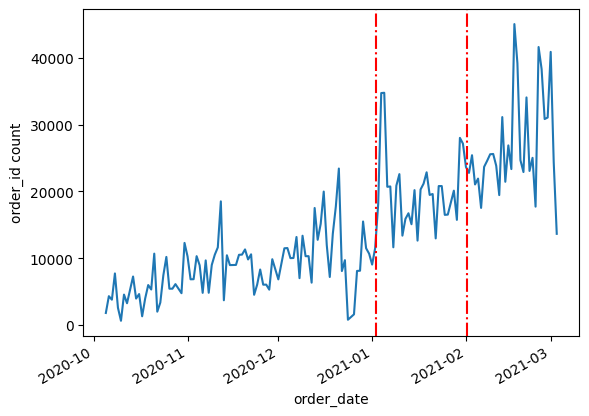

In [15]:
df_feature.groupby('order_date')['order_id'].count().plot(kind = 'line', ylabel='order_id count')
plt.axvline(x = test_split, color = 'r', linestyle = '-.')
plt.axvline(x = val_split, color = 'r', linestyle = '-.')

## 1. Try with numerical + binary data only 

In [16]:
cols_v1 = numeric_cols + binary_cols

In [17]:
X_train, y_train    = train_set[cols_v1], train_set[target]
X_val, y_val        = val_set[cols_v1], val_set[target]
X_test, y_test      = test_set[cols_v1], test_set[target]

#### RIDGE regression

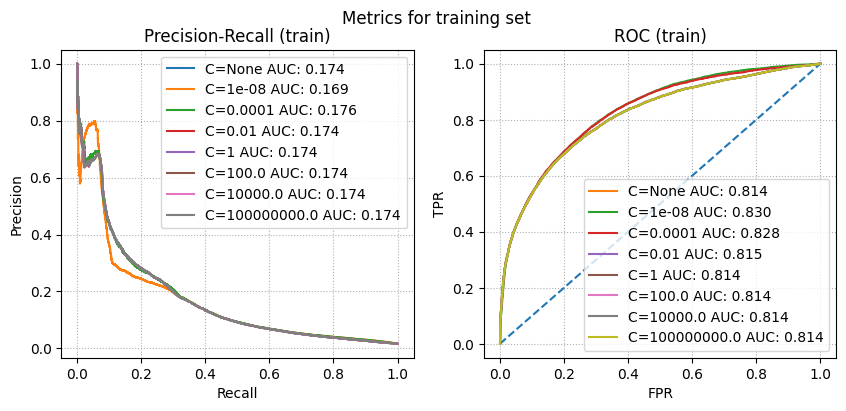

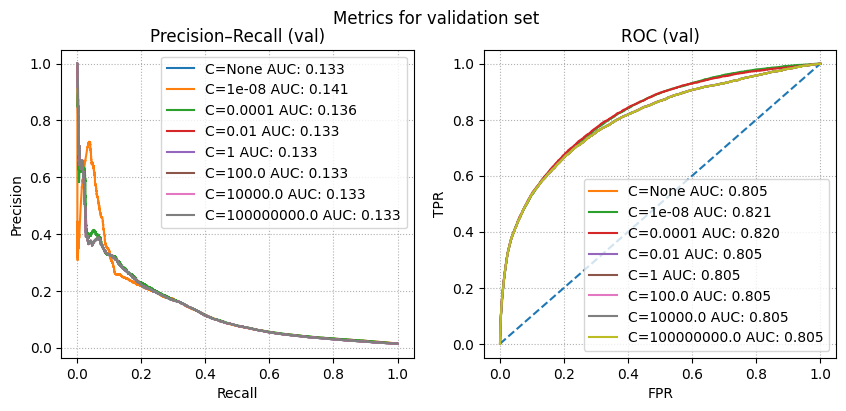

In [18]:
alphas = [None, 1e-8, 1e-4, 1e-2, 1, 1e2, 1e4, 1e8]

fig_tr, ax_tr = plt.subplots(1, 2, figsize=(10,4))
fig_tr.suptitle('Metrics for training set')
ax_tr[0].set_title('Precision-Recall (train)')
ax_tr[0].set_xlabel('Recall'); ax_tr[0].set_ylabel('Precision')
ax_tr[0].grid(True, ls=':')
ax_tr[1].set_title('ROC (train)')
ax_tr[1].set_xlabel('FPR'); ax_tr[1].set_ylabel('TPR')
ax_tr[1].plot([0,1],[0,1], ls='--')  # baseline
ax_tr[1].grid(True, ls=':')

fig_va, ax_va = plt.subplots(1, 2, figsize=(10,4))
fig_va.suptitle('Metrics for validation set')
ax_va[0].set_title('Precision–Recall (val)')
ax_va[0].set_xlabel('Recall'); ax_va[0].set_ylabel('Precision')
ax_va[0].grid(True, ls=':')
ax_va[1].set_title('ROC (val)')
ax_va[1].set_xlabel('FPR'); ax_va[1].set_ylabel('TPR')
ax_va[1].plot([0,1],[0,1], ls='--')
ax_va[1].grid(True, ls=':')

for a in alphas:
    ridge_clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty = 'l2', C = a if a else 1.0)
    )

    ridge_clf.fit(X_train, y_train)
    train_proba = ridge_clf.predict_proba(X_train)[:,1]

    precision_, recall_, _ = precision_recall_curve(y_train, train_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_train, train_proba)
    roc_auc = auc(fpr, tpr)

    ax_tr[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_tr[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

    ######## FOR VALIDATION DATA ########

    val_proba = ridge_clf.predict_proba(X_val)[:,1]

    precision_, recall_, _ = precision_recall_curve(y_val, val_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_val, val_proba)
    roc_auc = auc(fpr, tpr)

    ax_va[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_va[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

ax_tr[0].legend() ; ax_tr[1].legend()
ax_va[0].legend() ; ax_va[1].legend()

- Validation metrics are a bit lower than test metrics. But they are somehow similar, so it can be concluded that there is no overfitting.
- Lower values of C (larger alphas -> larger regularisation) seem to help in auc for both ROC and P-R curves.
- The dataset is biased because there are a lot of negative cases.


#### LASSO regression

c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\jontx\OneDrive\Documentos\.ZRIVE Applied Data Science\zrive-ds\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


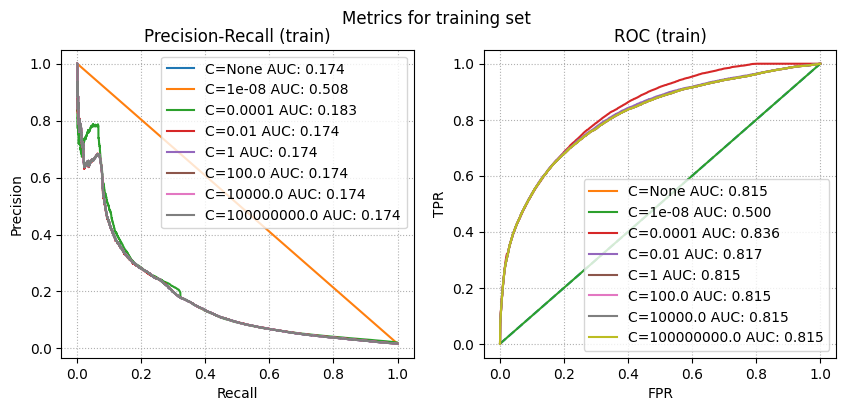

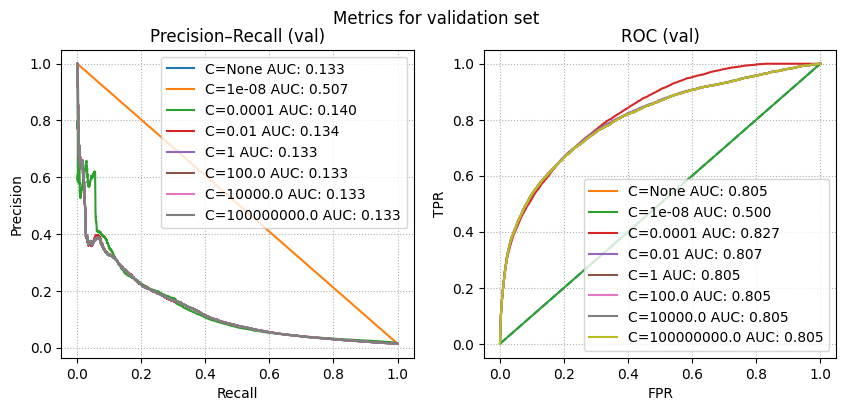

In [19]:
alphas = [None, 1e-8, 1e-4, 1e-2, 1, 1e2, 1e4, 1e8]

fig_tr, ax_tr = plt.subplots(1, 2, figsize=(10,4))
fig_tr.suptitle('Metrics for training set')
ax_tr[0].set_title('Precision-Recall (train)')
ax_tr[0].set_xlabel('Recall'); ax_tr[0].set_ylabel('Precision')
ax_tr[0].grid(True, ls=':')
ax_tr[1].set_title('ROC (train)')
ax_tr[1].set_xlabel('FPR'); ax_tr[1].set_ylabel('TPR')
ax_tr[1].plot([0,1],[0,1], ls='--')  # baseline
ax_tr[1].grid(True, ls=':')

fig_va, ax_va = plt.subplots(1, 2, figsize=(10,4))
fig_va.suptitle('Metrics for validation set')
ax_va[0].set_title('Precision–Recall (val)')
ax_va[0].set_xlabel('Recall'); ax_va[0].set_ylabel('Precision')
ax_va[0].grid(True, ls=':')
ax_va[1].set_title('ROC (val)')
ax_va[1].set_xlabel('FPR'); ax_va[1].set_ylabel('TPR')
ax_va[1].plot([0,1],[0,1], ls='--')
ax_va[1].grid(True, ls=':')

for a in alphas:
    lasso_clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty = 'l1', C = a if a else 1.0, solver = 'saga')
    )

    lasso_clf.fit(X_train, y_train)
    train_proba = lasso_clf.predict_proba(X_train)[:,1]

    precision_, recall_, _ = precision_recall_curve(y_train, train_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_train, train_proba)
    roc_auc = auc(fpr, tpr)

    ax_tr[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_tr[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

    ######## FOR VALIDATION DATA ########

    val_proba = lasso_clf.predict_proba(X_val)[:, 1]

    precision_, recall_, _ = precision_recall_curve(y_val, val_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_val, val_proba)
    roc_auc = auc(fpr, tpr)

    ax_va[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_va[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

ax_tr[0].legend() ; ax_tr[1].legend()
ax_va[0].legend() ; ax_va[1].legend()

- The case of C = 1e-8 is not working well.
- For the other cases, the behavior is pretty similar to Ridge and regularisation is working well

### Re-Train best model with train+val sets and check for test

In [24]:
X_tv = pd.concat([X_train, X_val], axis = 0, ignore_index=True)
y_tv = pd.concat([y_train, y_val], axis = 0, ignore_index = True)

In [25]:
print(len(X_tv) == len(X_train) + len(X_val))
print(len(y_tv) == len(y_train) + len(y_val))

True
True


I am going to pick the two best C values for both ridge and lasso and check which behaves better for the test set

#### RIDGE

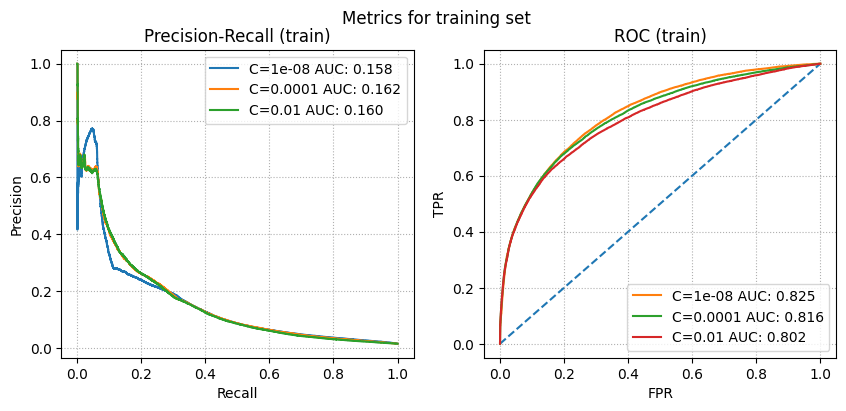

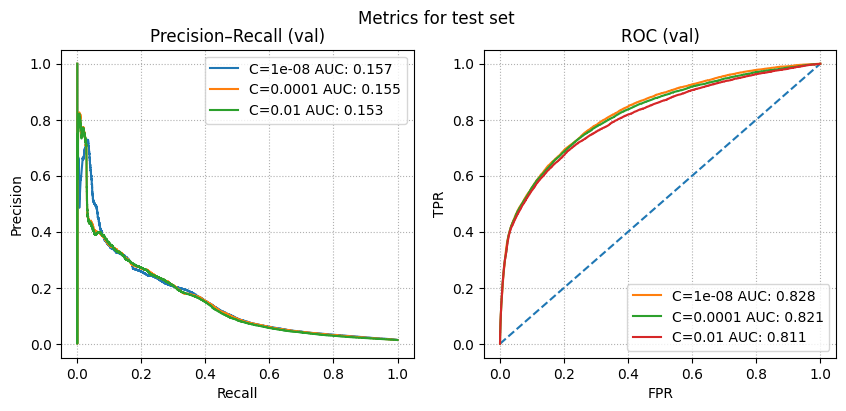

In [ ]:
alphas = [1e-8, 1e-4, 1e-2]

fig_tr, ax_tr = plt.subplots(1, 2, figsize=(10,4))
fig_tr.suptitle('Metrics for training set')
ax_tr[0].set_title('Precision-Recall (train)')
ax_tr[0].set_xlabel('Recall'); ax_tr[0].set_ylabel('Precision')
ax_tr[0].grid(True, ls=':')
ax_tr[1].set_title('ROC (train)')
ax_tr[1].set_xlabel('FPR'); ax_tr[1].set_ylabel('TPR')
ax_tr[1].plot([0,1],[0,1], ls='--')  # baseline
ax_tr[1].grid(True, ls=':')

fig_va, ax_va = plt.subplots(1, 2, figsize=(10,4))
fig_va.suptitle('Metrics for test set')
ax_va[0].set_title('Precision-Recall (val)')
ax_va[0].set_xlabel('Recall'); ax_va[0].set_ylabel('Precision')
ax_va[0].grid(True, ls=':')
ax_va[1].set_title('ROC (val)')
ax_va[1].set_xlabel('FPR'); ax_va[1].set_ylabel('TPR')
ax_va[1].plot([0,1],[0,1], ls='--')
ax_va[1].grid(True, ls=':')

for a in alphas:
    ridge_clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty = 'l2', C = a if a else 1.0)
    )

    ridge_clf.fit(X_tv, y_tv)
    tv_proba = ridge_clf.predict_proba(X_tv)[:,1]

    precision_, recall_, _ = precision_recall_curve(y_tv, tv_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_tv, tv_proba)
    roc_auc = auc(fpr, tpr)

    ax_tr[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_tr[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

    ######## FOR VALIDATION DATA ########

    test_proba = ridge_clf.predict_proba(X_test)[:,1]

    precision_, recall_, _ = precision_recall_curve(y_test, test_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_test, test_proba)
    roc_auc = auc(fpr, tpr)

    ax_va[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_va[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

ax_tr[0].legend() ; ax_tr[1].legend()
ax_va[0].legend() ; ax_va[1].legend()

<!-- - For training with **{train + val}**, the best results are with a **C = 1e-8** for the validation set using Ridge
- Results obtained for training and test sets are pretty similar, which indicates that the model is not overfitting
- Better behavior for C = 1e-8 in P-R curve comes from the oscillating part, which should not be considered. But for the rest of the range, the behavior is pretty similar in all the considered cases. 
- Same happens in the ROC curve. The interesting range (FPR < 0.3) is pretty similar for the three cases considered. 
- We are not interested in larger FPR because we would be considering as positive too many cases that are negative. And for our problem we do not want to disturb with push notifications to customers that won´t be predisposed to buy the advertised product. -->

#### Lasso

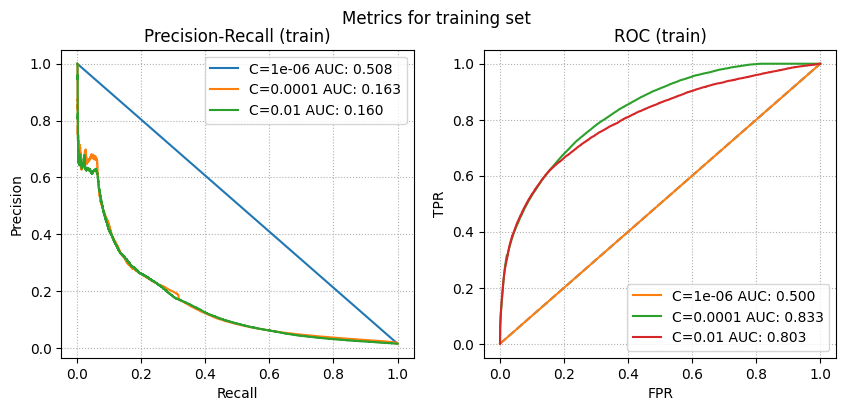

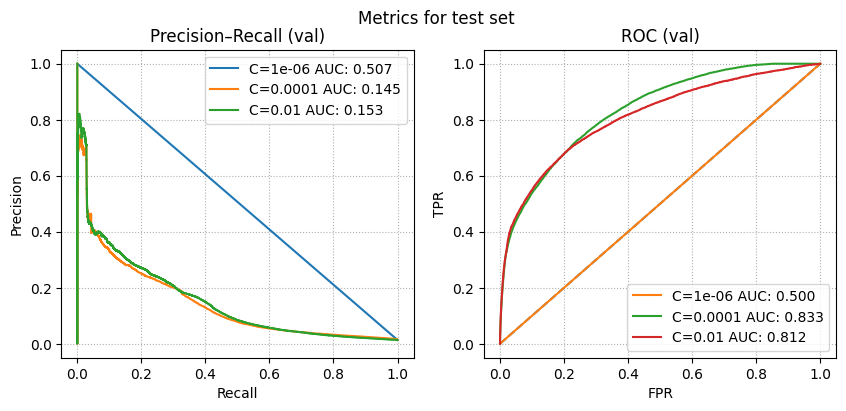

In [29]:
alphas = [1e-6, 1e-4, 1e-2]

fig_tr, ax_tr = plt.subplots(1, 2, figsize=(10,4))
fig_tr.suptitle('Metrics for training set')
ax_tr[0].set_title('Precision-Recall (train)')
ax_tr[0].set_xlabel('Recall'); ax_tr[0].set_ylabel('Precision')
ax_tr[0].grid(True, ls=':')
ax_tr[1].set_title('ROC (train)')
ax_tr[1].set_xlabel('FPR'); ax_tr[1].set_ylabel('TPR')
ax_tr[1].plot([0,1],[0,1], ls='--')  # baseline
ax_tr[1].grid(True, ls=':')

fig_va, ax_va = plt.subplots(1, 2, figsize=(10,4))
fig_va.suptitle('Metrics for test set')
ax_va[0].set_title('Precision–Recall (val)')
ax_va[0].set_xlabel('Recall'); ax_va[0].set_ylabel('Precision')
ax_va[0].grid(True, ls=':')
ax_va[1].set_title('ROC (val)')
ax_va[1].set_xlabel('FPR'); ax_va[1].set_ylabel('TPR')
ax_va[1].plot([0,1],[0,1], ls='--')
ax_va[1].grid(True, ls=':')

for a in alphas:
    lasso_clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty = 'l1', C = a if a else 1.0, solver = 'saga')
    )

    lasso_clf.fit(X_tv, y_tv)
    tv_proba = lasso_clf.predict_proba(X_tv)[:,1]

    precision_, recall_, _ = precision_recall_curve(y_tv, tv_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_tv, tv_proba)
    roc_auc = auc(fpr, tpr)

    ax_tr[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_tr[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

    ######## FOR VALIDATION DATA ########

    test_proba = lasso_clf.predict_proba(X_test)[:, 1]

    precision_, recall_, _ = precision_recall_curve(y_test, test_proba)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, thresholds = roc_curve(y_test, test_proba)
    roc_auc = auc(fpr, tpr)

    ax_va[0].plot(recall_, precision_, label = f'C={a} AUC: {pr_auc:.3f}')
    ax_va[1].plot(fpr, tpr, label = f'C={a} AUC: {roc_auc:.3f}')

ax_tr[0].legend() ; ax_tr[1].legend()
ax_va[0].legend() ; ax_va[1].legend()

- For lower C values, the model is not working well
- Lasso results are similar than Ridge for test predictions
- No overfitting